In [73]:
import numpy as np
import pandas as pd
import plotly.express as px
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## 1. Классификация предметов одежды (датасет Fashion MNIST)



### 1.1 Решить задачу классификации, не используя сверточные слои. 
* Предложить архитектуру модели для решения задачи
* Посчитать количество параметров модели.
* Обучить модель
* Вывести график функции потерь по эпохам. 
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
* Сохранить модель

In [2]:
mnist_train = datasets.FashionMNIST('./fashion_mnist/train', train=True,
                                    transform=transforms.Compose([transforms.ToTensor()]))
mnist_train

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./fashion_mnist/train
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [3]:
mnist_test = datasets.FashionMNIST('./fashion_mnist/test', train=False,
                                   transform=transforms.Compose([transforms.ToTensor()]))
mnist_test

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./fashion_mnist/test
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [4]:
device = 'cpu'  #  'mps' if torch.has_mps else 'cpu'

In [69]:
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(28 * 28, 2048),
    torch.nn.LeakyReLU(0.05),
    torch.nn.Linear(2048, 32),
    torch.nn.LeakyReLU(2),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(32, len(mnist_train.classes))
).to(device)

number_params = 0
for param in model.parameters():
    number_params += torch.prod(torch.tensor(param.shape))

number_params  # Количество параметров в сети

tensor(1673578)

In [70]:
def test_accuracy(_model, _test_loader, _loss_func) -> [float, float]:
    """ Возвращает два числа -- точность и лосс """
    acc = 0
    _loss = 0
    n = 0
    with torch.no_grad():
        for j, (_x, _y) in enumerate(_test_loader, 1):
            _x = _x.to(device)
            _y = _y.to(device)
            pred = model(_x)
            acc += torch.sum(torch.eq(pred.argmax(dim=1).long(), _y))
            n += pred.shape[0]
            _loss += _loss_func(pred, _y)

    return acc / n, _loss / j

In [95]:

def train(_model, train_data, test_data, epochs: int = 30, batch_size: int = 20_000) -> [torch.nn.Module, pd.DataFrame]:
    optimizer = torch.optim.Adam(_model.parameters(), weight_decay=0.0001)
    loss = torch.nn.CrossEntropyLoss()

    loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers=8)
    test_loader = DataLoader(test_data, batch_size=batch_size)
    _log = pd.DataFrame(columns=['epoch', 'train_loss', 'test_accuracy', 'test_loss'])

    for i in range(epochs + 1):
        epoch_loss = 0
        model.train()
        j = 1
        if i > 0:
            for j, (_x, _y) in enumerate(loader, 1):
                _x = _x.data.to(device)
                _y = _y.data.to(device)
                y_pred = _model(_x.data)
                running_loss = loss(y_pred, _y)
                running_loss.backward()

                epoch_loss += running_loss.item()

                optimizer.step()
                optimizer.zero_grad()

        model.eval()
        test_acc, test_loss = test_accuracy(model, test_loader, loss)
        _log.loc[i] = [i, epoch_loss / j, test_acc.item(), test_loss.item()]

        print(f'EPOCH: {i :3d}  |  LOSS: {epoch_loss / j: .4f}', end='  |  ')
        print(f'TEST LOSS: {test_loss:0.4f}  |  TEST ACCURACY: {test_acc:0.4f}')

    return _model, _log

In [72]:
model, log = train(model, mnist_train, mnist_test, 3, 100)

EPOCH:   0  |  LOSS:  2.3114  |  TEST LOSS: 2.3074  |  TEST ACCURACY: 0.0973
EPOCH:   1  |  LOSS:  0.5897  |  TEST LOSS: 0.4516  |  TEST ACCURACY: 0.8399
EPOCH:   2  |  LOSS:  0.4327  |  TEST LOSS: 0.4232  |  TEST ACCURACY: 0.8457
EPOCH:   3  |  LOSS:  0.3966  |  TEST LOSS: 0.3625  |  TEST ACCURACY: 0.8672


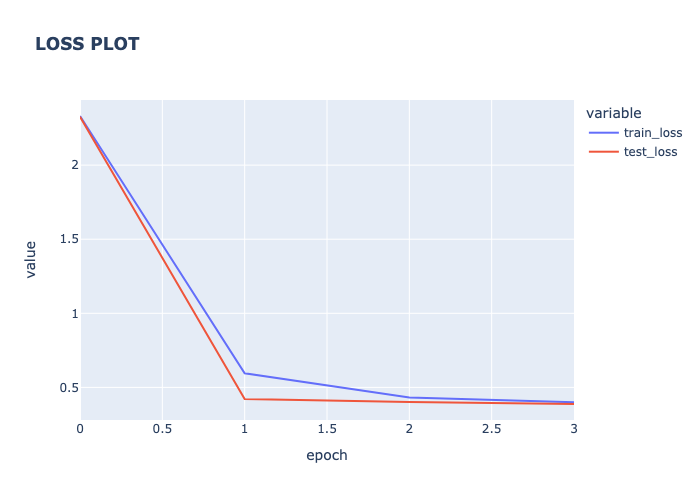

In [15]:
px.line(log, x='epoch', y=['train_loss', 'test_loss'], title='<b>LOSS PLOT</b>').show(renderer='png')

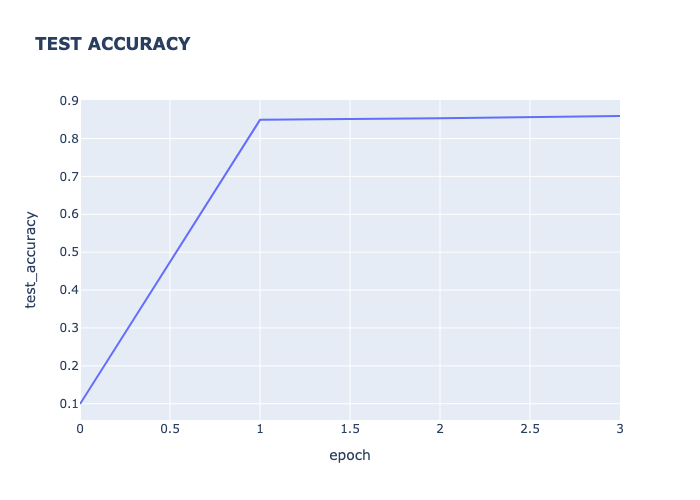

In [16]:
px.line(log, x='epoch', y='test_accuracy', title='<b>TEST ACCURACY</b>').show(renderer='png')

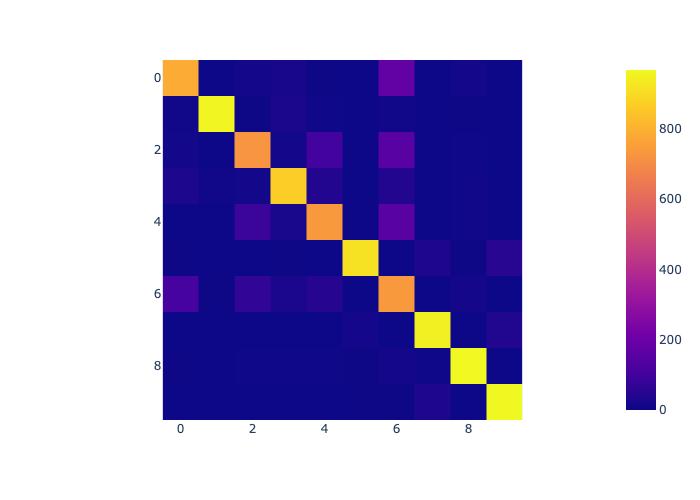

In [17]:
from sklearn.metrics import confusion_matrix

model.to('cpu')
right_ans = torch.zeros(mnist_test.data.shape[0]).to('cpu')
with torch.no_grad():
    i = 0
    for x, _ in DataLoader(mnist_test, batch_size=2000):
        x = x.to('cpu')
        right_ans[i:i + x.shape[0]] += model(x).argmax(dim=1)
        i += x.shape[0]

cm = confusion_matrix(mnist_test.targets.numpy(), right_ans.long().numpy())
px.imshow(cm).show(renderer='png')

In [18]:
torch.save(model.state_dict(), 'models/mnist_linear')

CLASS : 1 (Trouser)  |  PREDICTED CLASS : 3 (Dress)


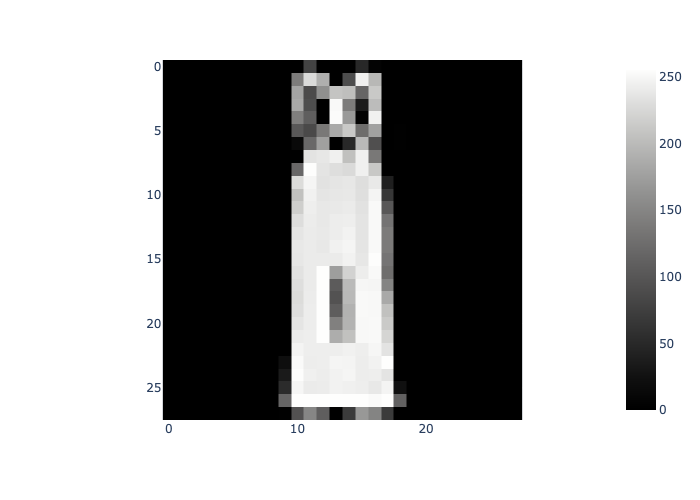

CLASS : 7 (Sneaker)  |  PREDICTED CLASS : 7 (Sneaker)


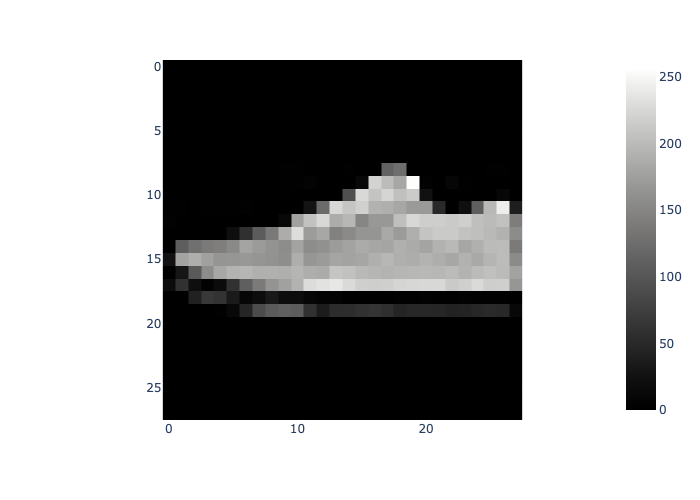

CLASS : 9 (Ankle boot)  |  PREDICTED CLASS : 9 (Ankle boot)


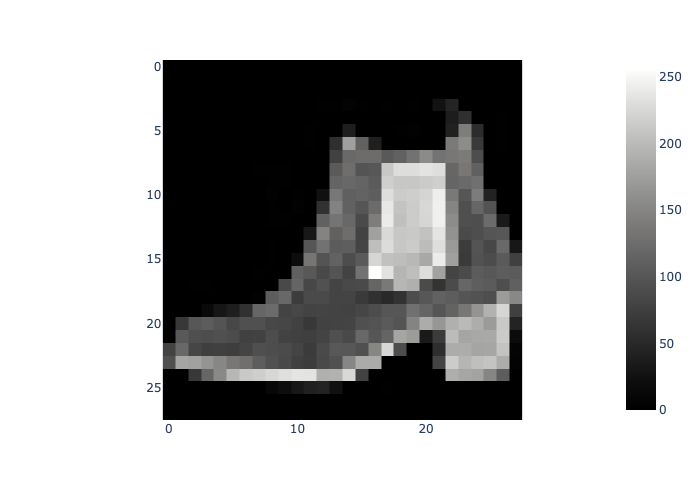

In [19]:
np.random.seed(21)
for i in np.random.randint(0, mnist_test.targets.shape[0], 3):
    id_class = mnist_test.targets[i]
    class_name = mnist_test.classes[id_class]

    id_predicted = model(mnist_test.data[i:i + 1].float()).argmax(dim=1).item()
    class_name_predicted = mnist_test.classes[id_predicted]
    print(f'CLASS : {id_class} ({class_name})  |  '
          f'PREDICTED CLASS : {id_predicted} ({class_name_predicted})')
    px.imshow(mnist_test.data[i], color_continuous_scale='gray').show(renderer='png')

### 1.2 Решить задачу 1.1, используя сверточную нейронную сеть. 
* Добиться значения accuracy на тестовом множестве не менее 90%
* Визуализировать результаты работы первого сверточного слоя

In [20]:
mnist_train = datasets.FashionMNIST('./fashion_mnist/train', train=True,
                                    transform=transforms.Compose([transforms.ToTensor()]))
mnist_test = datasets.FashionMNIST('./fashion_mnist/test', train=False,
                                   transform=transforms.Compose([transforms.ToTensor()]))
mnist_train

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./fashion_mnist/train
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [21]:
p = 0.2

model = torch.nn.Sequential(

    torch.nn.BatchNorm2d(1),

    torch.nn.Conv2d(1, 8, (3, 3), padding=1),
    torch.nn.BatchNorm2d(8),
    torch.nn.ReLU(),

    torch.nn.Conv2d(8, 64, (3, 3), padding=1),
    torch.nn.MaxPool2d((2, 2)),
    torch.nn.BatchNorm2d(64),
    torch.nn.ReLU(),

    torch.nn.Dropout(p),

    torch.nn.Flatten(),
    torch.nn.Linear(12544, 2048),
    torch.nn.Sigmoid(),
    torch.nn.Linear(2048, 10)

).to(device)

In [22]:
number_params = 0
for param in model.parameters():
    number_params += torch.prod(torch.tensor(param.shape))

number_params  # Количество параметров в сети

tensor(25717548)

In [23]:
model, log = train(model, mnist_train, mnist_test, 3, 500)

EPOCH:   0  |  LOSS:  2.3223  |  TEST LOSS: 2.3224  |  TEST ACCURACY: 0.1347
EPOCH:   1  |  LOSS:  0.4822  |  TEST LOSS: 0.3188  |  TEST ACCURACY: 0.8813
EPOCH:   2  |  LOSS:  0.2554  |  TEST LOSS: 0.2667  |  TEST ACCURACY: 0.8993
EPOCH:   3  |  LOSS:  0.2111  |  TEST LOSS: 0.2484  |  TEST ACCURACY: 0.9093


In [24]:
model.eval()

Sequential(
  (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Conv2d(8, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Dropout(p=0.2, inplace=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=12544, out_features=2048, bias=True)
  (11): Sigmoid()
  (12): Linear(in_features=2048, out_features=10, bias=True)
)

CLASS : tensor([9]) (Ankle boot)


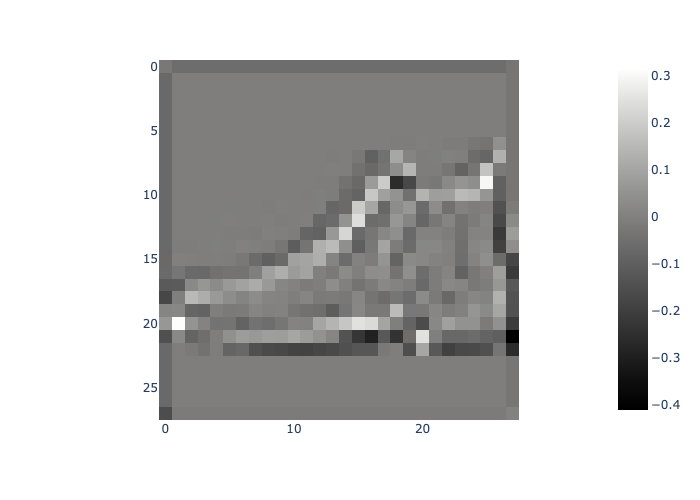

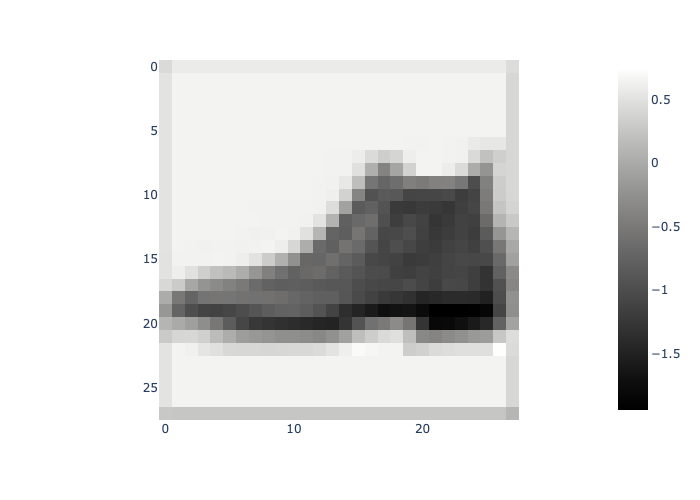

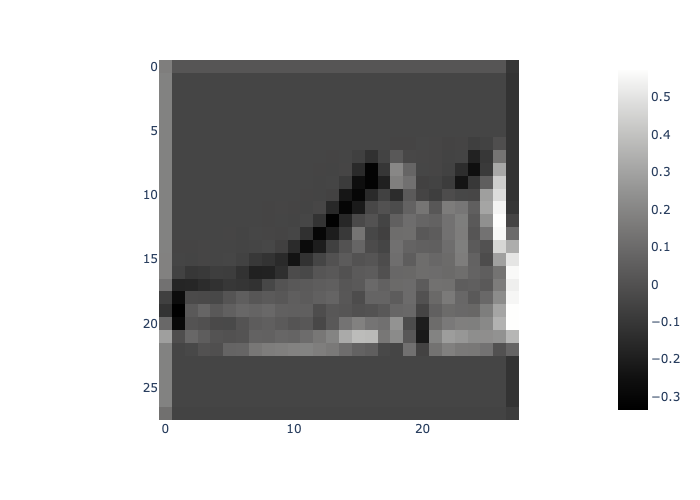

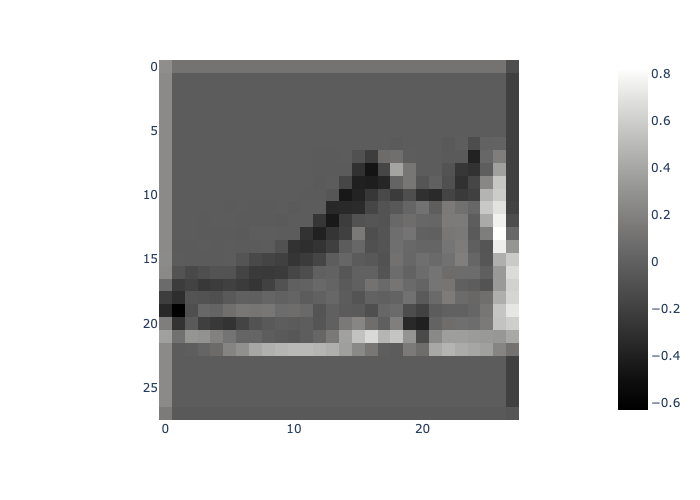

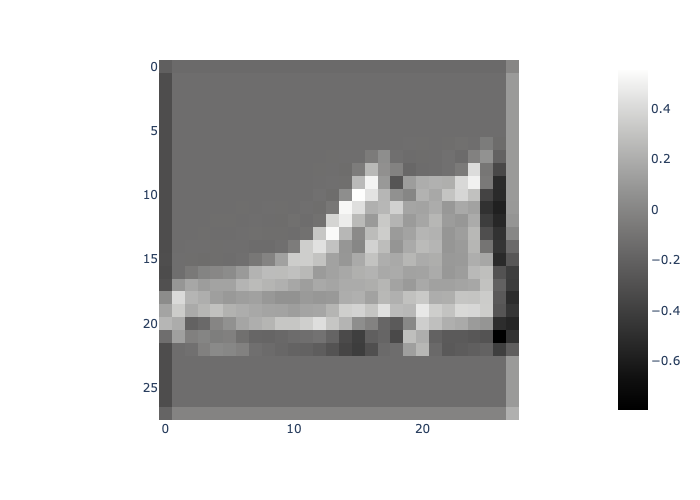

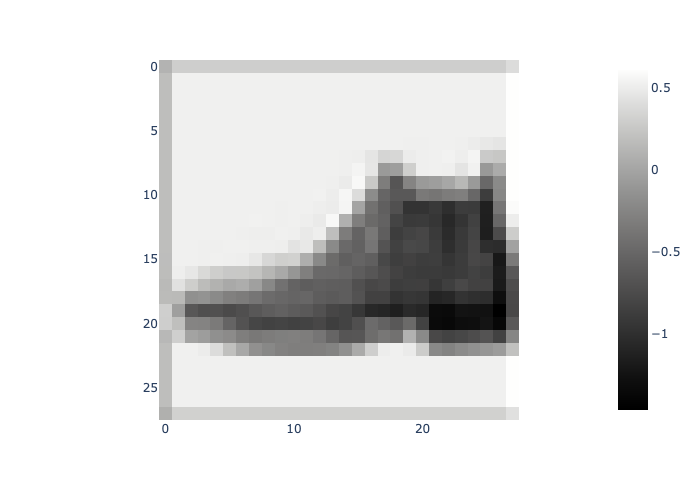

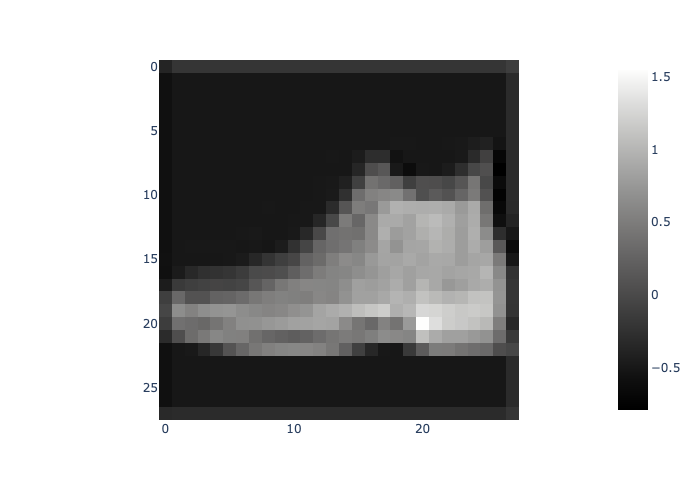

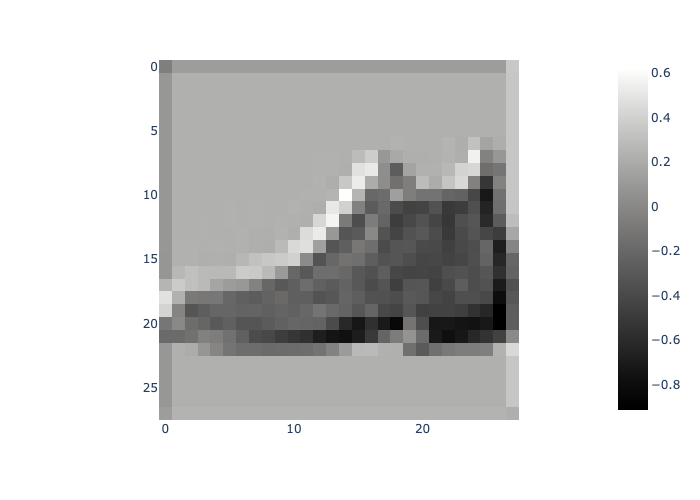

In [25]:
from plotly.subplots import make_subplots

np.random.seed(21)

pic, target = next(iter(DataLoader(mnist_test, batch_size=1)))
fst_pic = model[:2](pic)[0]

print(f'CLASS : {target} ({mnist_test.classes[target]})')
for pic_i in fst_pic:
    fig = make_subplots(1, 2)
    px.imshow(pic_i.detach().numpy(), color_continuous_scale='gray').show(renderer='png')

##  2. Классификация изображений (датасет CIFAR 10) 


### 2.1 Решить задачу классификации, не используя сверточные слои. 

* Нормализовать данные (если необходимо)
* Предложить архитектуру модели для решения задачи
* Посчитать количество параметров модели.
* Обучить модель
* Вывести график функции потерь по эпохам. 
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
* Сохранить модель

In [26]:
class TensorReshape:
    def __call__(self, _x):
        return _x.reshape(3, 32, 32)

    def __repr__(self):
        return 'TensorReshape()'

In [27]:
cifar_train = datasets.CIFAR10('./cifar_mnist/train', train=True, download=False,
                               transform=transforms.Compose([transforms.ToTensor(), TensorReshape()]))

cifar_test = datasets.CIFAR10('./cifar_mnist/train', train=False, download=False,
                              transform=transforms.Compose([transforms.ToTensor(), TensorReshape()]))
cifar_test

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./cifar_mnist/train
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               TensorReshape()
           )

In [28]:
model = torch.nn.Sequential(
    torch.nn.BatchNorm2d(3),
    torch.nn.Flatten(),
    torch.nn.Linear(3 * 32 * 32, 2048),
    torch.nn.LeakyReLU(0.05),
    torch.nn.Linear(2048, 32),
    torch.nn.LeakyReLU(2),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(32, len(cifar_train.classes))
).to(device)

number_params = 0
for param in model.parameters():
    number_params += torch.prod(torch.tensor(param.shape))

number_params  # Количество параметров в сети

tensor(6359408)

In [29]:
model, log = train(model, cifar_train, cifar_test, epochs=2, batch_size=500)

EPOCH:   0  |  LOSS:  2.3595  |  TEST LOSS: 2.3369  |  TEST ACCURACY: 0.0926
EPOCH:   1  |  LOSS:  2.0467  |  TEST LOSS: 1.5534  |  TEST ACCURACY: 0.4582
EPOCH:   2  |  LOSS:  1.6744  |  TEST LOSS: 1.4725  |  TEST ACCURACY: 0.4843


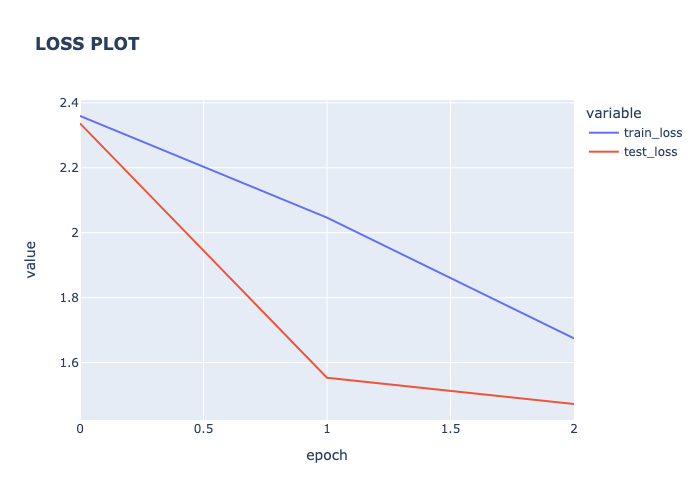

In [30]:
import plotly.express as px

px.line(log, x='epoch', y=['train_loss', 'test_loss'], title='<b>LOSS PLOT</b>').show(renderer='png')

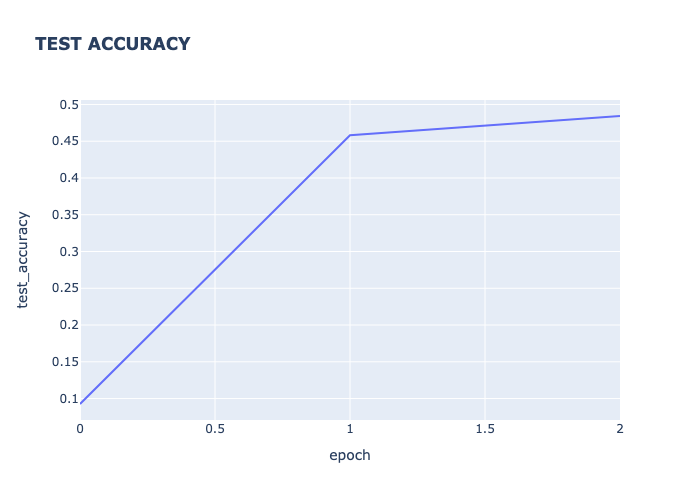

In [31]:
px.line(log, x='epoch', y='test_accuracy', title='<b>TEST ACCURACY</b>').show(renderer='png')

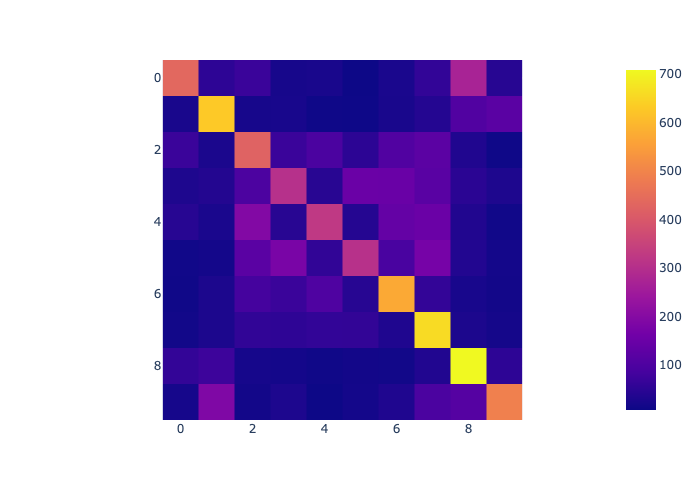

In [32]:
from sklearn.metrics import confusion_matrix

model.eval()
model.to('cpu')
right_ans = torch.zeros(cifar_test.data.shape[0]).to('cpu')
with torch.no_grad():
    i = 0
    for x, _ in DataLoader(cifar_test, batch_size=2000):
        x = x.to('cpu')
        right_ans[i:i + x.shape[0]] += model(x).argmax(dim=1)
        i += x.shape[0]

cm = confusion_matrix(cifar_test.targets, right_ans.long().numpy())
px.imshow(cm).show(renderer='png')

In [33]:
torch.save(model.state_dict(), 'models/cifar_linear')

In [34]:
model

Sequential(
  (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=3072, out_features=2048, bias=True)
  (3): LeakyReLU(negative_slope=0.05)
  (4): Linear(in_features=2048, out_features=32, bias=True)
  (5): LeakyReLU(negative_slope=2)
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=32, out_features=10, bias=True)
)

CLASS : 0 (airplane)  |  PREDICTED CLASS : 8 (ship)


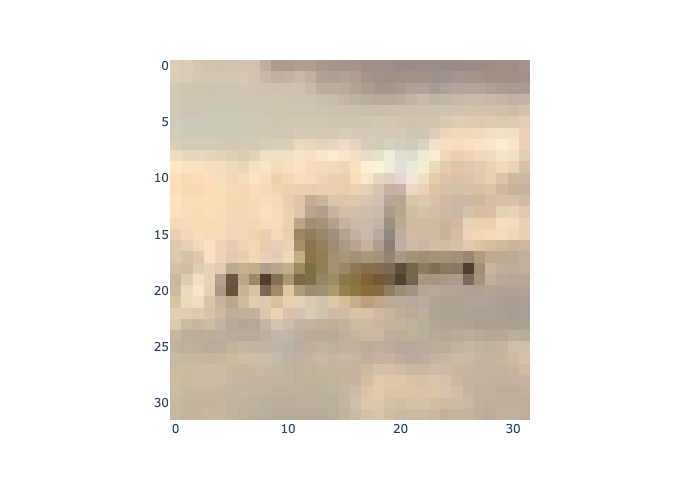

CLASS : 2 (bird)  |  PREDICTED CLASS : 8 (ship)


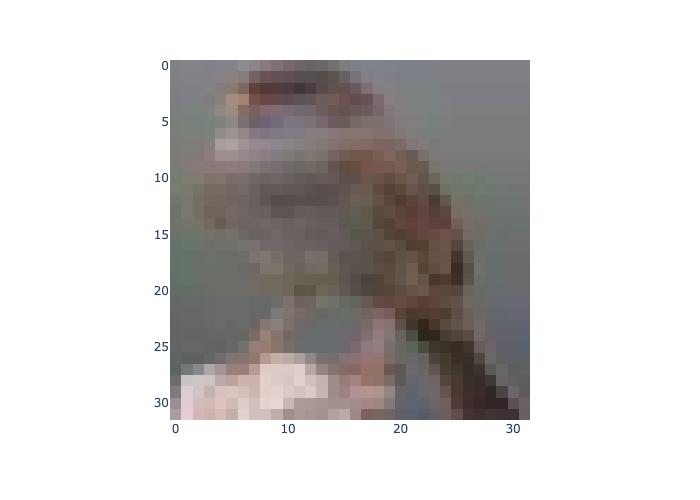

CLASS : 0 (airplane)  |  PREDICTED CLASS : 2 (bird)


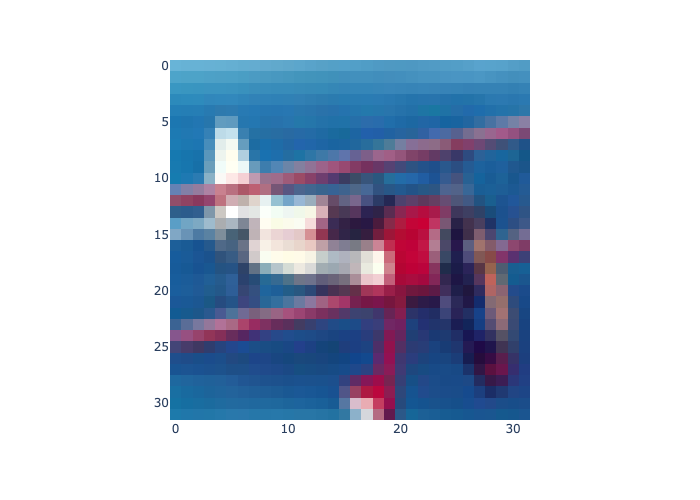

In [35]:
np.random.seed(21)
model.eval()
for i in np.random.randint(0, cifar_test.targets.__len__(), 3):
    id_class = cifar_test.targets[i]
    class_name = cifar_test.classes[id_class]
    image = torch.tensor(cifar_test.data[i:i + 1]).float().reshape(1, 3, 32, 32)

    id_predicted = model(image).argmax(axis=1).item()
    class_name_predicted = cifar_test.classes[id_predicted]
    print(f'CLASS : {id_class} ({class_name})  |  '
          f'PREDICTED CLASS : {id_predicted} ({class_name_predicted})')
    px.imshow(cifar_test.data[i], color_continuous_scale='gray').show(renderer='png')

### 2.2 Решить задачу 2.1, используя сверточную нейронную сеть. 
* Добиться значения accuracy на тестовом множестве не менее 70%.
* Визуализировать результаты работы первого сверточного слоя

In [36]:
model = torch.nn.Sequential(

    torch.nn.BatchNorm2d(3),
    torch.nn.Conv2d(3, 16, (3, 3), padding=1),
    torch.nn.MaxPool2d((2, 2)),
    torch.nn.ReLU(),

    torch.nn.BatchNorm2d(16),
    torch.nn.Conv2d(16, 64, (3, 3), padding=1),
    torch.nn.MaxPool2d((2, 2)),
    torch.nn.ReLU(),

    torch.nn.BatchNorm2d(64),
    torch.nn.Conv2d(64, 64, (3, 3), padding=1),
    torch.nn.ReLU(),

    torch.nn.BatchNorm2d(64),
    torch.nn.Conv2d(64, 128, (3, 3), padding=1),
    torch.nn.MaxPool2d((2, 2)),
    torch.nn.ReLU(),

    torch.nn.Flatten(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(16 * 128, len(cifar_train.classes))
).to(device)

number_params = 0
for param in model.parameters():
    number_params += torch.prod(torch.tensor(param.shape))

number_params  # Количество параметров в сети

tensor(141296)

In [38]:
model, log = train(model, cifar_train, cifar_test, epochs=3, batch_size=100)

EPOCH:   0  |  LOSS:  2.4076  |  TEST LOSS: 2.3495  |  TEST ACCURACY: 0.1054
EPOCH:   1  |  LOSS:  1.2883  |  TEST LOSS: 0.9489  |  TEST ACCURACY: 0.6687
EPOCH:   2  |  LOSS:  0.9159  |  TEST LOSS: 0.7868  |  TEST ACCURACY: 0.7270
EPOCH:   3  |  LOSS:  0.7823  |  TEST LOSS: 0.7287  |  TEST ACCURACY: 0.7532


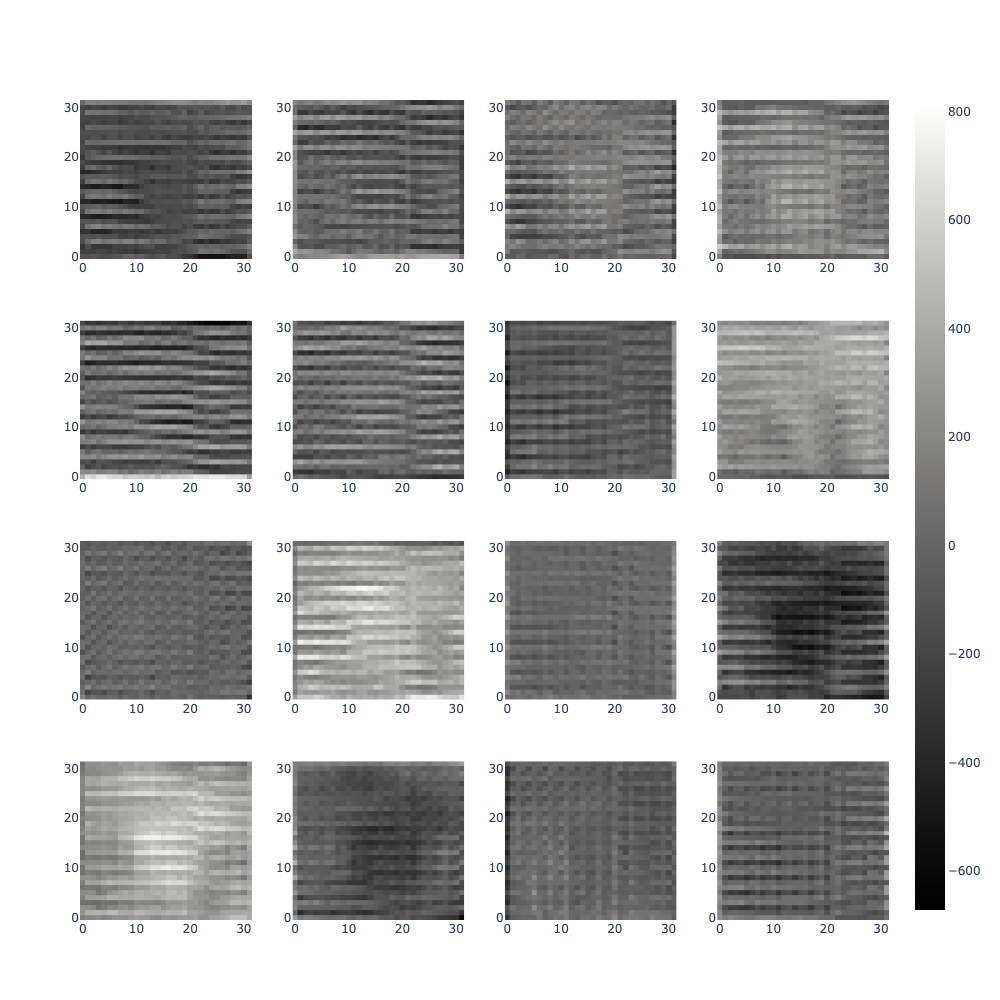

In [40]:
from plotly.subplots import make_subplots

fig = make_subplots(rows=4, cols=4)

images = model[:2](torch.tensor(cifar_test.data[20:21].reshape(1, 3, 32, 32)).float()).reshape(16, 32,
                                                                                               32).detach().numpy()

for n, image in enumerate(images):
    fig.add_trace(px.imshow(image).data[0], row=n // 4 + 1, col=n % 4 + 1)

layout = px.imshow(images[0], color_continuous_scale='gray').layout
fig.layout.coloraxis = layout.coloraxis
# fig.update_xaxes(**layout.xaxis.to_plotly_json())
# fig.update_yaxes(**layout.yaxis.to_plotly_json())
fig.show(autoscale=False, height=1000, width=1000, renderer='png')

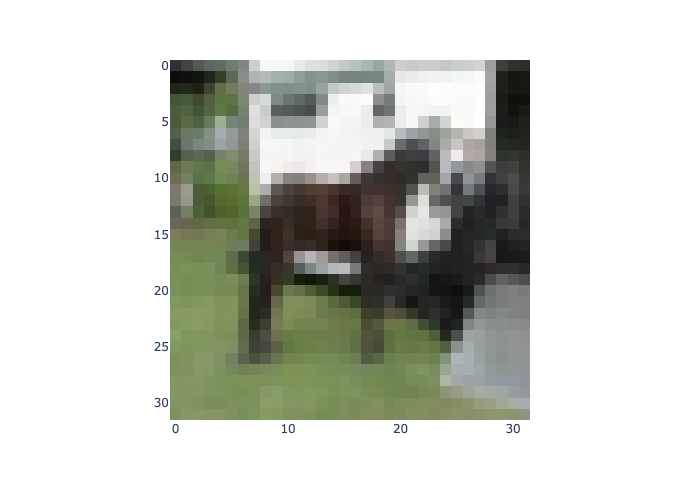

In [41]:
px.imshow(cifar_test.data[20:21].reshape(32, 32, 3)).show(renderer='png')

## 3. Загрузка изображений из внешних источников

### 3.1 Решить задачу классификации обезьян (датасет [monkey.zip](https://disk.yandex.ru/d/OxYgY4S7aR6ulQ)).
* Загрузить архив с данными на диск
* Создать датасет на основе файлов при помощи `torchvision.datasets.ImageFolder`
* Преобразовать изображения к тензорами одного размера (например, 400х400). Потестировать другие преобразования из `torchvision.transforms`
* Предложить архитектуру модели для решения задачи. Обучить модель.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
  * Добиться значения accuracy на тестовом множестве не менее 60%

In [42]:
# from google.colab import drive
#
# drive.mount('/content/drive')

# import zipfile
# from tqdm import tqdm
#
# zf = zipfile.ZipFile('drive/MyDrive/datasets/monkeys.zip')
# for file in tqdm(zf.infolist()):
#     zf.extract(file)


In [166]:
from torchvision.datasets import ImageFolder

monkey_train = ImageFolder(
    './monkeys/training/training',
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.RandomRotation((-20, 20)),
            transforms.RandomHorizontalFlip(),
            transforms.Resize((512, 512))
        ]
    )
)

monkey_test = ImageFolder(
    './monkeys/validation/validation',
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize((512, 512))
        ]
    )
)
next(iter(DataLoader(monkey_test, batch_size=10, shuffle=True)))  # Работает!!

[tensor([[[[0.3176, 0.3176, 0.3176,  ..., 0.6980, 0.7078, 0.7095],
           [0.3137, 0.3137, 0.3137,  ..., 0.6980, 0.7057, 0.7053],
           [0.3101, 0.3101, 0.3101,  ..., 0.6980, 0.7009, 0.6983],
           ...,
           [0.2936, 0.2980, 0.3001,  ..., 0.1837, 0.1993, 0.2024],
           [0.3081, 0.3034, 0.2974,  ..., 0.1836, 0.1840, 0.1964],
           [0.3046, 0.3019, 0.3007,  ..., 0.1982, 0.1722, 0.1759]],
 
          [[0.4549, 0.4549, 0.4516,  ..., 0.7098, 0.7196, 0.7212],
           [0.4510, 0.4510, 0.4510,  ..., 0.7098, 0.7175, 0.7170],
           [0.4473, 0.4473, 0.4473,  ..., 0.7098, 0.7127, 0.7101],
           ...,
           [0.3948, 0.3991, 0.3920,  ..., 0.1567, 0.1693, 0.1710],
           [0.3983, 0.3936, 0.3876,  ..., 0.1640, 0.1562, 0.1650],
           [0.3948, 0.3897, 0.3831,  ..., 0.1786, 0.1526, 0.1562]],
 
          [[0.3373, 0.3373, 0.3439,  ..., 0.6353, 0.6451, 0.6467],
           [0.3333, 0.3333, 0.3333,  ..., 0.6353, 0.6430, 0.6425],
           [0.3297, 0.32

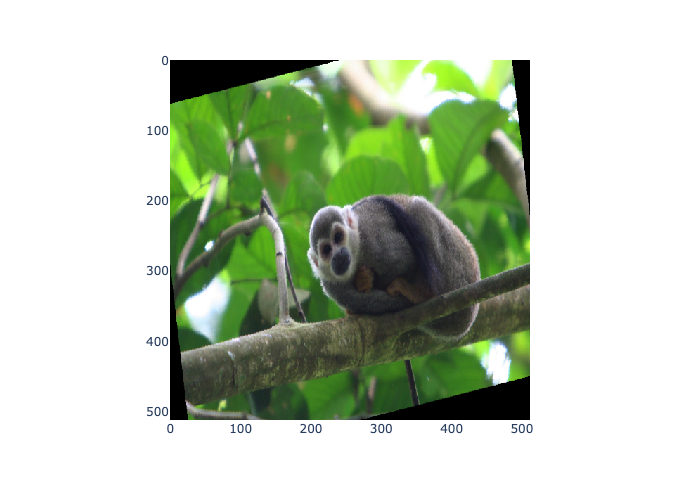

In [168]:
pic = next(iter(DataLoader(monkey_train, batch_size=1, shuffle=True)))[0][0]
px.imshow(pic.permute(1, 2, 0), ).show(renderer='png')

In [172]:
%%time
model = torch.nn.Sequential(
    
    torch.nn.BatchNorm2d(3),
    torch.nn.Conv2d(3, 16, (3, 3), stride=2),
    torch.nn.MaxPool2d((2, 2)),
    torch.nn.CELU(),

    torch.nn.BatchNorm2d(16),
    torch.nn.Conv2d(16, 128, (3, 3), stride=2),
    torch.nn.MaxPool2d((2, 2)),
    torch.nn.CELU(),

    torch.nn.BatchNorm2d(128),
    torch.nn.Conv2d(128, 128, (3, 3), stride=2),
    torch.nn.MaxPool2d((2, 2)),
    torch.nn.CELU(),

    torch.nn.Flatten(),
    torch.nn.Linear(512, 128),
    torch.nn.CELU(),
    torch.nn.Linear(128, 10)
)

pic = next(iter(DataLoader(monkey_train, batch_size=2, shuffle=True)))[0]
model(pic)

CPU times: user 76.7 ms, sys: 29.2 ms, total: 106 ms
Wall time: 51.8 ms


tensor([[-0.3546, -0.0541, -0.1210,  0.1147, -0.2675,  0.3577, -0.2713,  0.3063,
         -0.0617, -0.1104],
        [-0.1940, -0.1719, -0.2236,  0.0808, -0.0502,  0.1620, -0.1008,  0.0531,
         -0.1078, -0.1213]], grad_fn=<AddmmBackward0>)

In [173]:
%%time 
model, log = train(model, monkey_train, monkey_test, epochs=5, batch_size=100)

EPOCH:   0  |  LOSS:  0.0000  |  TEST LOSS: 2.3022  |  TEST ACCURACY: 0.0919
EPOCH:   1  |  LOSS:  1.9524  |  TEST LOSS: 2.4513  |  TEST ACCURACY: 0.1691
EPOCH:   2  |  LOSS:  1.4556  |  TEST LOSS: 2.2154  |  TEST ACCURACY: 0.2426
EPOCH:   3  |  LOSS:  1.2122  |  TEST LOSS: 1.4725  |  TEST ACCURACY: 0.5331
EPOCH:   4  |  LOSS:  1.0725  |  TEST LOSS: 1.2288  |  TEST ACCURACY: 0.5699
EPOCH:   5  |  LOSS:  0.9498  |  TEST LOSS: 1.0407  |  TEST ACCURACY: 0.6581
CPU times: user 3min 6s, sys: 1min 42s, total: 4min 48s
Wall time: 6min 40s


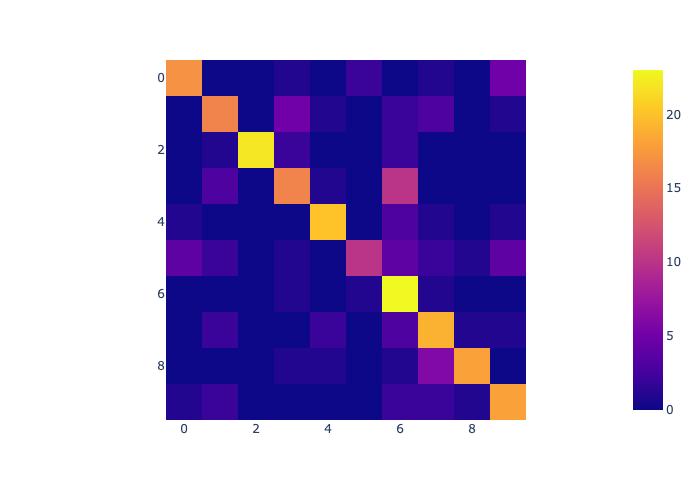

In [174]:
model.eval()
model.to('cpu')
right_ans = torch.zeros(len(monkey_test.targets)).to('cpu')
with torch.no_grad():
    i = 0
    for x, _ in DataLoader(monkey_test, batch_size=2000):
        x = x.to('cpu')
        right_ans[i:i + x.shape[0]] += model(x).argmax(dim=1)
        i += x.shape[0]

cm = confusion_matrix(monkey_test.targets, right_ans.long().numpy())
px.imshow(cm).show(renderer='png')

In [176]:
monkey_names = pd.read_csv('monkeys/monkey_labels.txt', sep=',', index_col='Label')

CLASS : 7 (mantled_howler)  |  PREDICTED CLASS : 0 (mantled_howler)


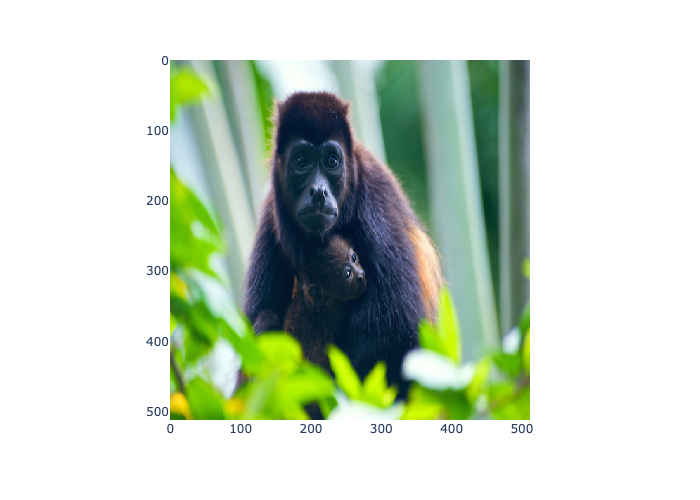

CLASS : 7 (mantled_howler)  |  PREDICTED CLASS : 5 (white_headed_capuchin)


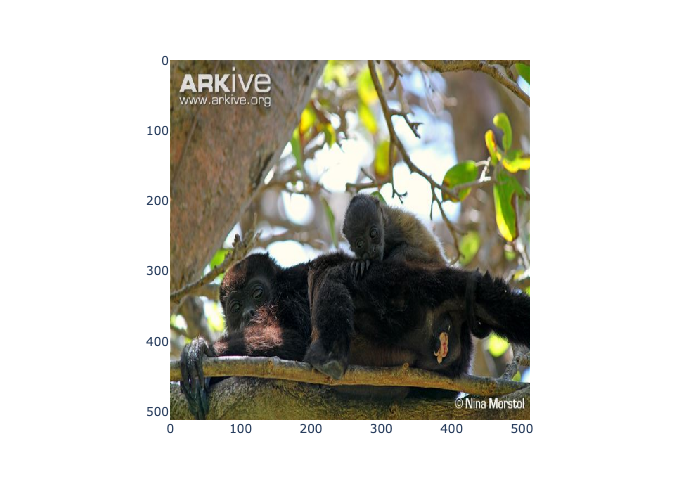

CLASS : 7 (mantled_howler)  |  PREDICTED CLASS : 0 (mantled_howler)


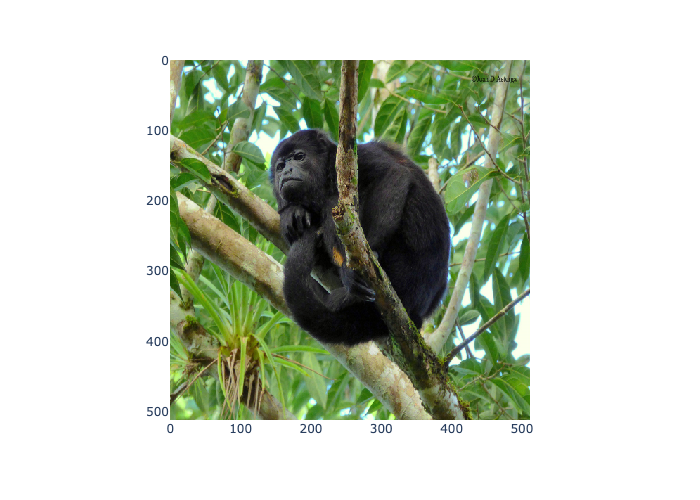

CLASS : 7 (mantled_howler)  |  PREDICTED CLASS : 0 (mantled_howler)


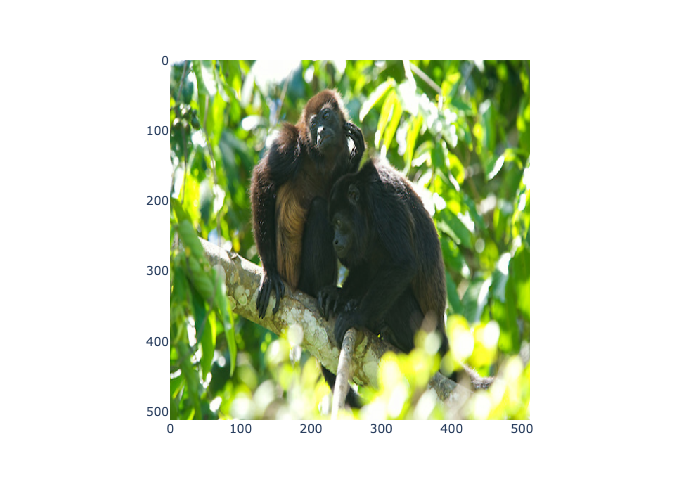

CLASS : 7 (mantled_howler)  |  PREDICTED CLASS : 0 (mantled_howler)


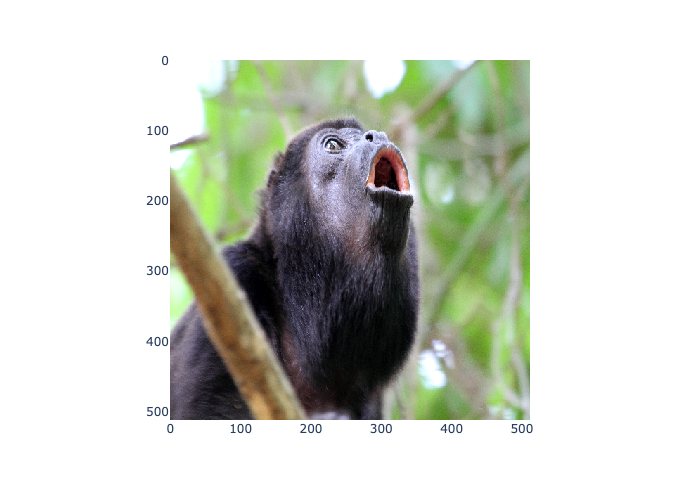

CLASS : 7 (mantled_howler)  |  PREDICTED CLASS : 0 (mantled_howler)


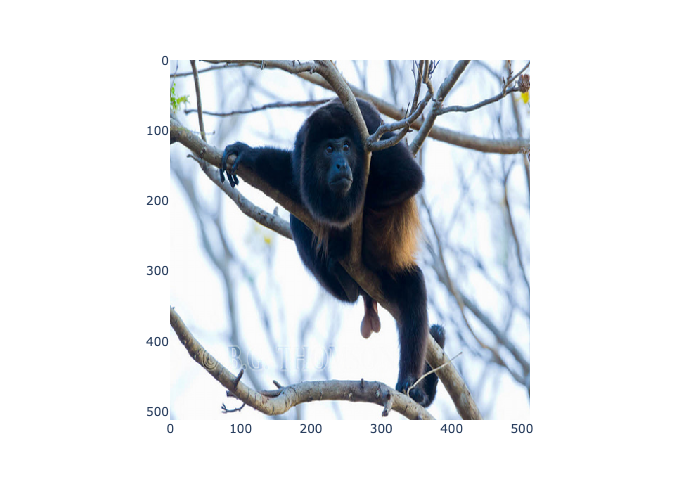

CLASS : 7 (mantled_howler)  |  PREDICTED CLASS : 9 (nilgiri_langur)


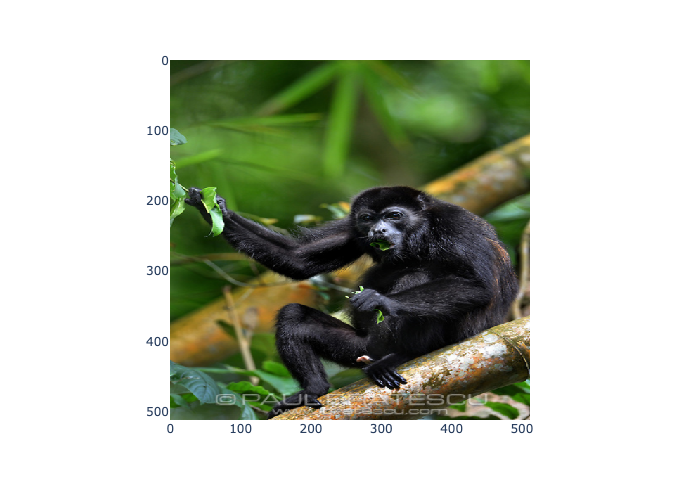

CLASS : 7 (mantled_howler)  |  PREDICTED CLASS : 0 (mantled_howler)


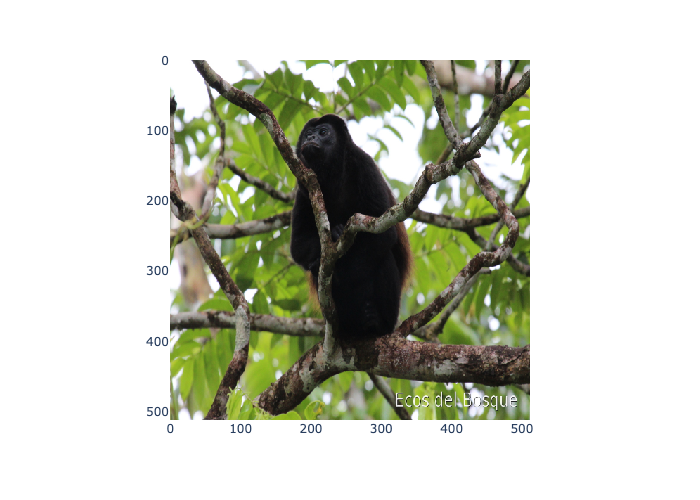

CLASS : 7 (mantled_howler)  |  PREDICTED CLASS : 7 (common_squirrel_monkey)


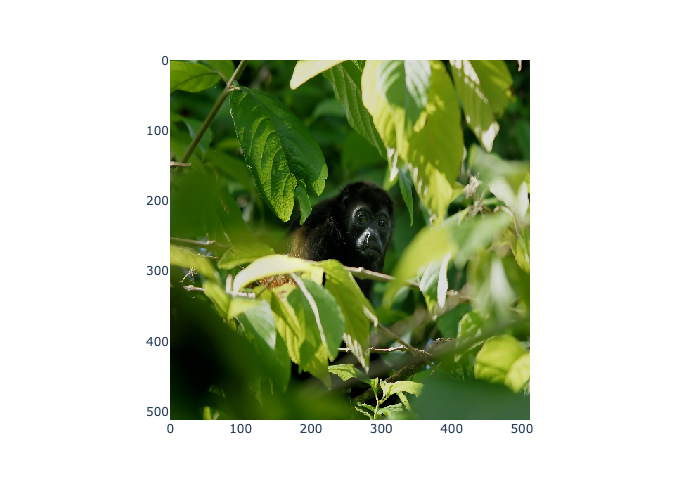

CLASS : 7 (mantled_howler)  |  PREDICTED CLASS : 0 (mantled_howler)


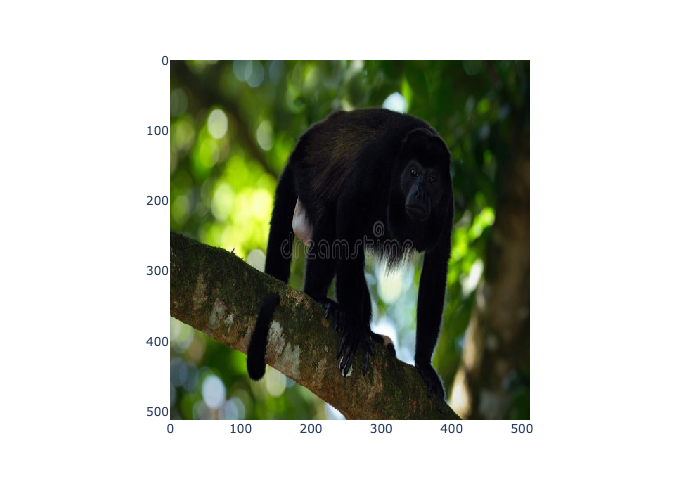

CLASS : 7 (mantled_howler)  |  PREDICTED CLASS : 9 (nilgiri_langur)


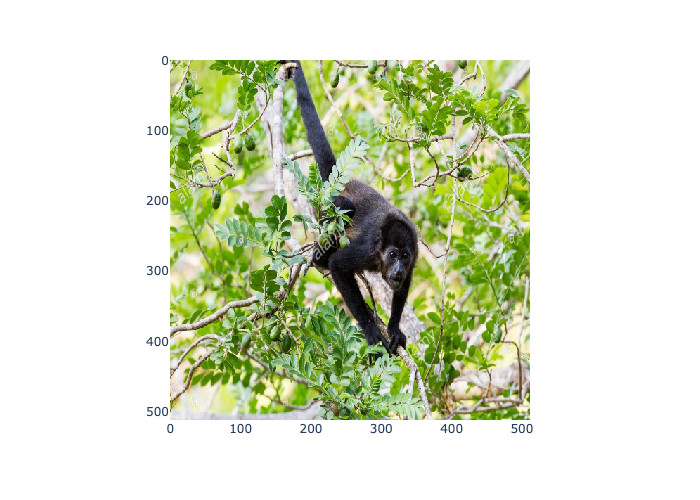

In [178]:
np.random.seed(21)
model.eval()
i = 10

for image, name in DataLoader(monkey_test):
    class_name = monkey_names.iloc[int(name), 1]
    id_predicted = model(image).argmax(axis=1).item()
    class_name_predicted = monkey_names.iloc[int(id_predicted), 1]
    image = image.reshape(3, 512, 512).permute(1, 2, 0)
    
    print(f'CLASS : {id_class} ({class_name})  |  '
          f'PREDICTED CLASS : {id_predicted} ({class_name_predicted})')
    px.imshow(image, color_continuous_scale='gray').show(renderer='png')
    
    if i == 0:
        break
    i -= 1

### 3.2 Решить задачу классификации собак и кошек (датасет [cats_dogs.zip](https://disk.yandex.ru/d/wQtt5O1JF9ctnA)).
* Загрузить архив с данными на диск
* Создать датасет на основе файлов при помощи `torchvision.datasets.ImageFolder`
* Преобразовать изображения к тензорами одного размера (например, 400х400). Потестировать другие преобразования из `torchvision.transforms`
* Предложить архитектуру модели для решения задачи. Обучить модель.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
  * Добиться значения accuracy на тестовом множестве не менее 80%

In [185]:
# pip install split-folders

# from splitfolders import ratio

# ratio('./cats_dogs/train/', './cats_dogs_splitted/')

In [186]:
from torchvision.datasets import ImageFolder

catdog_train = ImageFolder(
    './cats_dogs_splitted/train/',
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.RandomRotation((-20, 20)),
            transforms.RandomHorizontalFlip(),
            transforms.Resize((512, 512))
        ]
    )
)

catdog_test = ImageFolder(
    './cats_dogs_splitted/test/',
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.RandomRotation((-20, 20)),
            transforms.RandomHorizontalFlip(),
            transforms.Resize((512, 512))
        ]
    )
)

catdog_val = ImageFolder(
    './cats_dogs_splitted/val/',
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.RandomRotation((-20, 20)),
            transforms.RandomHorizontalFlip(),
            transforms.Resize((512, 512))
        ]
    )
)

next(iter(DataLoader(monkey_test, batch_size=10, shuffle=True)))

[tensor([[[[0.4157, 0.4178, 0.4050,  ..., 0.5070, 0.5343, 0.5451],
           [0.5832, 0.5650, 0.5269,  ..., 0.5058, 0.5136, 0.5125],
           [0.6681, 0.6492, 0.6130,  ..., 0.5047, 0.5012, 0.4944],
           ...,
           [0.6793, 0.6993, 0.7199,  ..., 0.4230, 0.4487, 0.4257],
           [0.6841, 0.7004, 0.7172,  ..., 0.4730, 0.4631, 0.4248],
           [0.6863, 0.7013, 0.7166,  ..., 0.4999, 0.4637, 0.4314]],
 
          [[0.3961, 0.3982, 0.3825,  ..., 0.4050, 0.4210, 0.4275],
           [0.5549, 0.5331, 0.4908,  ..., 0.4044, 0.3983, 0.3905],
           [0.6278, 0.6030, 0.5619,  ..., 0.4021, 0.3823, 0.3669],
           ...,
           [0.7323, 0.7512, 0.7709,  ..., 0.5108, 0.5419, 0.5236],
           [0.7368, 0.7531, 0.7695,  ..., 0.5630, 0.5604, 0.5286],
           [0.7412, 0.7562, 0.7706,  ..., 0.5921, 0.5631, 0.5373]],
 
          [[0.1804, 0.2191, 0.2481,  ..., 0.3618, 0.3779, 0.3843],
           [0.3348, 0.3473, 0.3482,  ..., 0.3596, 0.3532, 0.3430],
           [0.3961, 0.40

In [192]:
%%time
model = torch.nn.Sequential(
    
    torch.nn.BatchNorm2d(3),
    torch.nn.Conv2d(3, 8, (4, 4), stride=3),
    torch.nn.MaxPool2d((4, 4)),
    torch.nn.CELU(),

    torch.nn.BatchNorm2d(8),
    torch.nn.Conv2d(8, 128, (4, 4), stride=3),
    torch.nn.MaxPool2d((5, 5)),
    torch.nn.CELU(),

    torch.nn.Flatten(),
    torch.nn.Linear(512, 128),
    torch.nn.CELU(),
    torch.nn.Linear(128, 10)
)

pic = next(iter(DataLoader(monkey_train, batch_size=2, shuffle=True)))[0]
model(pic)

CPU times: user 162 ms, sys: 37.6 ms, total: 199 ms
Wall time: 77.1 ms


tensor([[-7.4746e-02,  7.8705e-02, -6.3182e-02, -1.4647e-01, -8.2821e-02,
         -3.1685e-01,  2.2558e-01,  2.5753e-01, -1.9481e-01, -1.0586e-01],
        [-1.3736e-01,  4.7883e-03, -3.9349e-04, -7.1434e-02, -7.1646e-02,
         -3.3557e-01,  1.2563e-01, -1.7405e-02, -4.4294e-01, -7.9899e-02]],
       grad_fn=<AddmmBackward0>)

In [193]:
%%time 
model, log = train(model, catdog_train, catdog_test, epochs=5, batch_size=100)

EPOCH:   0  |  LOSS:  0.0000  |  TEST LOSS: 2.2857  |  TEST ACCURACY: 0.0036
EPOCH:   1  |  LOSS:  0.6326  |  TEST LOSS: 0.5404  |  TEST ACCURACY: 0.7376


ERROR: Unexpected segmentation fault encountered in worker.
 

RuntimeError: DataLoader worker (pid 32247) is killed by signal: Segmentation fault: 11. 

# 4. Transfer Learning

### 4.1 Решить задачу 3.1, воспользовавшись предобученной моделью VGG16
* Загрузить данные для обучения
* Преобразования: размер 224x224, нормализация с параметрами `mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`
* Заменить последний полносвязный слой модели в соответствии с задачей
* Дообучить модель (не замораживать веса). Вычислить значение accuracy на тестовом множестве
* Дообучить модель (заморозить все веса, кроме последнего блока слоев (`classifier`)). 
* Вычислить значение accuracy на тестовом множестве.


### 4.2 Решить задачу 3.2, воспользовавшись подходящей предобученной моделью
* Не использовать VGG16 (вместо нее можно взять resnet18 или другую)
* Загрузить данные для обучения
* Преобразования: размер 224x224, нормализация с параметрами `mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`
* Заменить последний полносвязный слой модели в соответствии с задачей
* Дообучить модель. 
* Вычислить значение accuracy на тестовом множестве (добиться значения не меньше 97-98%)